In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from tqdm import tqdm
import pandas as pd
from pandas import DataFrame
from obp.utils import softmax

from dataset.synthetic import SyntheticBanditDatasetWithCluster
from policy.policylearners import TruePolicyLearner
from utils.common import visualize_learning_curve

In [2]:
# setting
n_users=50
dim_context=10
n_actions=100
n_cat_per_dim=10
n_cat_dim=5
n_clusters=20
beta=0.5
beta_user=2.0
reward_noise=3.0
random_state=12345
n_sim=30
val_size=1000
test_size=1000
hidden_layer_size=(30, 30, 30)
max_iter=31

In [3]:
def calc_policy_value(p_u, pi, q_x_a):
    return (p_u[:, None] * pi * q_x_a).sum()

def calc_new1_value(p_u, pi, q_x_a, squared_q_x_a):
    squared_policy_value = (p_u[:, None] * pi * squared_q_x_a).sum()
    policy_value = (p_u[:, None] * pi * q_x_a).sum()
    reg_term = squared_policy_value - (policy_value ** 2)
    return policy_value - reg_term

def calc_new2_value(p_u, pi, q_x_a):
    q_u = (pi * q_x_a).sum(1)
    policy_value = (p_u * q_u).sum()
    reg_term = (p_u * (q_u ** 2)).sum() - (policy_value ** 2)
    return policy_value - reg_term

In [4]:
dataset = SyntheticBanditDatasetWithCluster(
    n_users=n_users,
    dim_context=dim_context,
    n_actions=n_actions,
    n_cat_per_dim=n_cat_per_dim,
    n_cat_dim=n_cat_dim,
    n_clusters=n_clusters,
    beta=beta,
    beta_user=beta_user,
    reward_noise=reward_noise,
    random_state=random_state
)
n_clusters = dataset.n_clusters
q_x_a = dataset.q_x_a
p_u = dataset.p_u
x_u = dataset.user_contexts
squared_q_x_a = dataset.squared_q_x_a

pi_b = softmax(beta * q_x_a)

pi_b_value = calc_policy_value(p_u, pi_b, q_x_a)
pi_b_new1_value = calc_new1_value(p_u, pi_b, q_x_a, squared_q_x_a)
pi_b_new2_value = calc_new2_value(p_u, pi_b, q_x_a)

value_df, new1_value_df, new2_value_df = DataFrame(), DataFrame(), DataFrame()
for _ in tqdm(range(n_sim)):
    
    # Generalization
    generalization = TruePolicyLearner(
        dim_context=dim_context, 
        num_actions=n_actions,
        max_iter=max_iter,
        hidden_layer_size=hidden_layer_size,
        learning_rate_init=0.05,
    )
    generalization.fit(p_u=p_u, x_u=x_u, q_x_a=q_x_a, squared_q_x_a=squared_q_x_a)
    
    gen_value_ = DataFrame([generalization.test_value, ["Generalization"] * max_iter], index=["value", "method"]).T.reset_index()
    gen_new1_value_ = DataFrame([generalization.new1_value, ["Generalization"] * max_iter], index=["value", "method"]).T.reset_index()
    gen_new2_value_ = DataFrame([generalization.new2_value, ["Generalization"] * max_iter], index=["value", "method"]).T.reset_index()
    
    
    #  - \mathbb{V}_{x,a,r \sim \pi_{\theta}}[r] regularization
    new1 = TruePolicyLearner(
        dim_context=dim_context, 
        num_actions=n_actions,
        max_iter=max_iter,
        hidden_layer_size=hidden_layer_size,
        learning_rate_init=0.05,
        regularization_type="all_variance",
    )
    new1.fit(p_u=p_u, x_u=x_u, q_x_a=q_x_a, squared_q_x_a=squared_q_x_a)
    
    new1_value_ = DataFrame([new1.test_value, ["New1"] * max_iter], index=["value", "method"]).T.reset_index()
    new1_new1_value_ = DataFrame([new1.new1_value, ["New1"] * max_iter], index=["value", "method"]).T.reset_index()
    new1_new2_value_ = DataFrame([new1.new2_value, ["New1"] * max_iter], index=["value", "method"]).T.reset_index()
    
    # - \mathbb{V}_{x}[\mathbb{E}_{a,r \sim \pi_{\theta}}[r]] regularization
    new2 = TruePolicyLearner(
        dim_context=dim_context, 
        num_actions=n_actions,
        max_iter=max_iter,
        hidden_layer_size=hidden_layer_size,
        learning_rate_init=0.05,
        regularization_type="x_variance"
    )
    new2.fit(p_u=p_u, x_u=x_u, q_x_a=q_x_a, squared_q_x_a=squared_q_x_a)

    new2_value_ = DataFrame([new2.test_value, ["New2"] * max_iter], index=["value", "method"]).T.reset_index()
    new2_new1_value_ = DataFrame([new2.new1_value, ["New2"] * max_iter], index=["value", "method"]).T.reset_index()
    new2_new2_value_ = DataFrame([new2.new2_value, ["New2"] * max_iter], index=["value", "method"]).T.reset_index()
    
    
    value_df = pd.concat([value_df, pd.concat([gen_value_, new1_value_, new2_value_])])
    new1_value_df = pd.concat([new1_value_df, pd.concat([gen_new1_value_, new1_new1_value_, new2_new1_value_])])
    new2_value_df = pd.concat([new2_value_df, pd.concat([gen_new2_value_, new1_new2_value_, new2_new2_value_])])
    
value_df.reset_index(inplace=True) 
value_df["pi_b_value"] = pi_b_value
value_df["rel_value"] = value_df["value"] / pi_b_value

new1_value_df.reset_index(inplace=True) 
new1_value_df["pi_b_value"] = pi_b_new1_value
new1_value_df["rel_value"] = new1_value_df["value"] / pi_b_new1_value

new2_value_df.reset_index(inplace=True) 
new2_value_df["pi_b_value"] = pi_b_new2_value
new2_value_df["rel_value"] = new2_value_df["value"] / pi_b_new2_value

100% 30/30 [00:15<00:00,  1.95it/s]


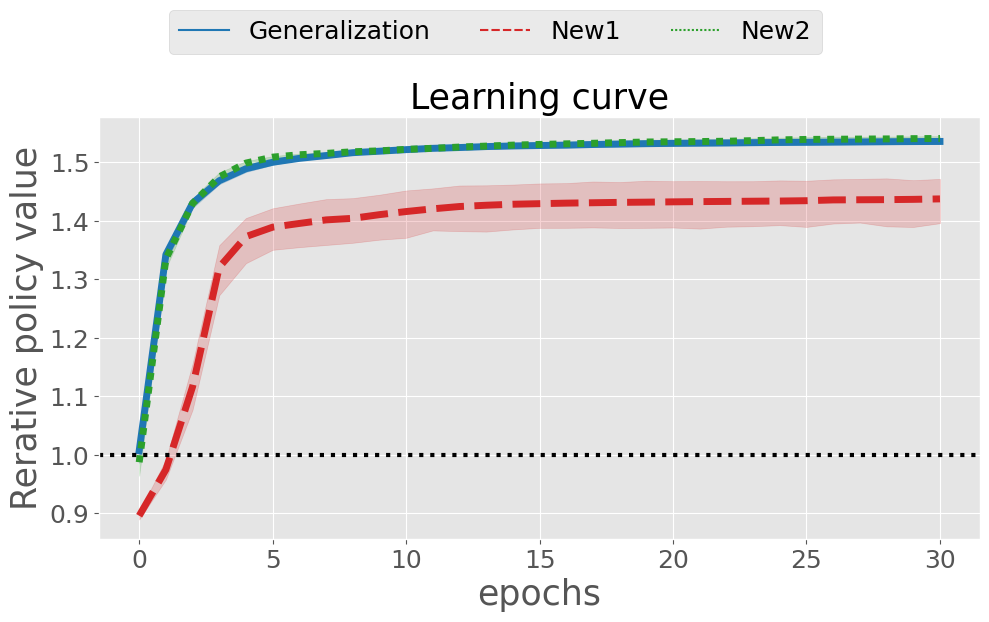

In [5]:
# curve of policy value i.e., \mathbb{E}_{x,a,r \sim \pi_{\theta}}[r]
visualize_learning_curve(value_df)

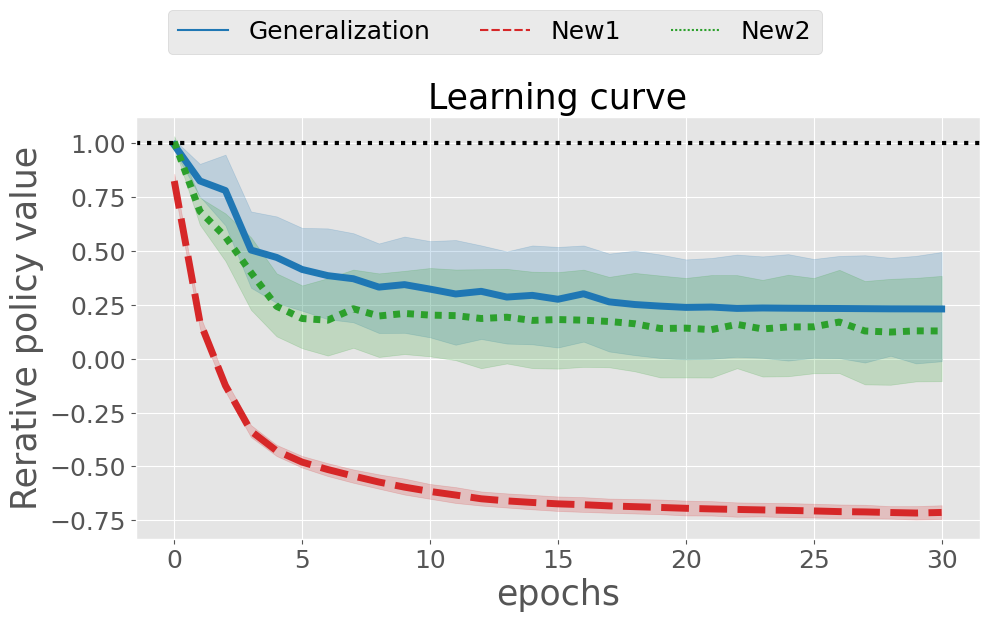

In [6]:
# curve of new1 value 
#i.e., \mathbb{E}_{x,a,r \sim \pi_{\theta}}[r] - \mathbb{V}_{x,a,r \sim \pi_{\theta}}[r]
visualize_learning_curve(new1_value_df)

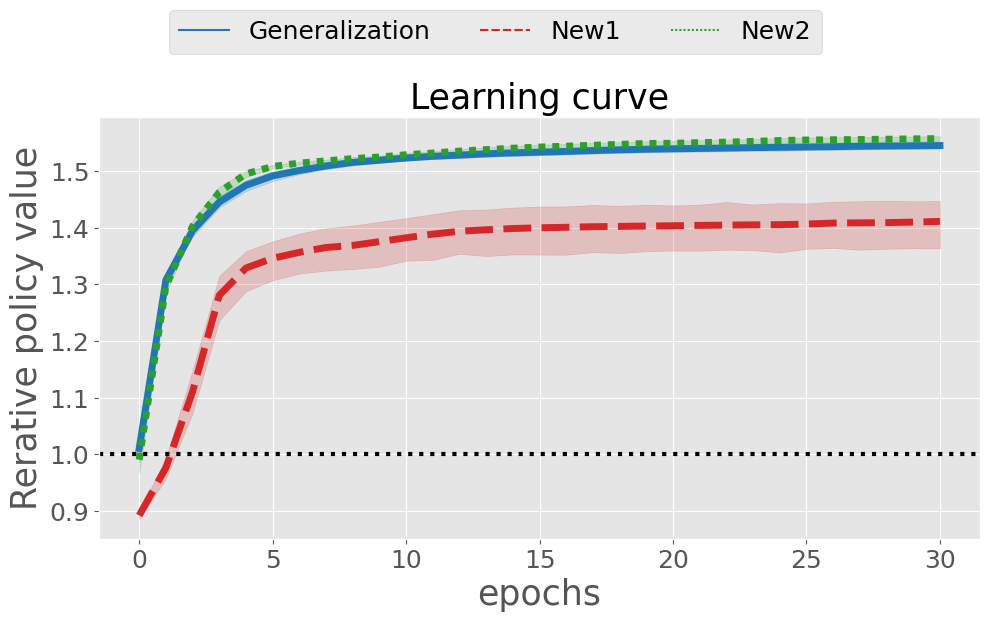

In [7]:
# curve of new2 value 
# i.e., \mathbb{E}_{x,a,r \sim \pi_{\theta}}[r] - \mathbb{V}_{x}[\mathbb{E}_{a,r \sim \pi_{\theta}}[r]]
visualize_learning_curve(new2_value_df)

In [8]:
def calc_sigma_value(p_u, pi, sigma_x_a):
    return (p_u[:, None] * pi * sigma_x_a).sum()

In [9]:
sigma_x_a = dataset.sigma_x_a
pi = generalization.predict(x_u)
pi1 = new1.predict(x_u)
pi2 = new2.predict(x_u)

pi_sigma = calc_sigma_value(p_u, pi, sigma_x_a)
pi1_sigma = calc_sigma_value(p_u, pi1, sigma_x_a)
pi2_sigma = calc_sigma_value(p_u, pi2, sigma_x_a)

print(f"gen: {pi_sigma}, new1: {pi1_sigma}, new2: {pi2_sigma}")

gen: 1.1767168513256272, new1: 0.2517407897079129, new2: 1.1513490733996714


In [10]:
# new1's policy value is the most confidence! and second performance 